Raw shape: (2688, 4)
Columns: ['dispatching_base_number', 'date', 'active_vehicles', 'trips']

Sample rows:
  dispatching_base_number        date  active_vehicles  trips
0                  B02512  2014-04-01              792   1011
1                  B02682  2014-04-01              112   6255
2                  B02598  2014-04-01             3613   3738
3                  B02764  2014-04-01              112    323
4                  B02617  2014-04-01             2778   3219

====== GLOBAL SUMMARY ======
Date range: 2014-04-01 to 2015-06-30
Total trips (sum over rows): 18,804,806
Total active vehicles (sum over rows): 3,743,153
Unique dispatching bases: 8
Time span (days): 455

Trips by month (top rows):
date
2014-04-01    564516
2014-05-01    652435
2014-06-01    663844
2014-07-01    796121
2014-08-01    829275
Name: trips, dtype: int64

Top 10 dispatching bases by total active_vehicles:
                                mean      sum   max  count
dispatching_base_number                

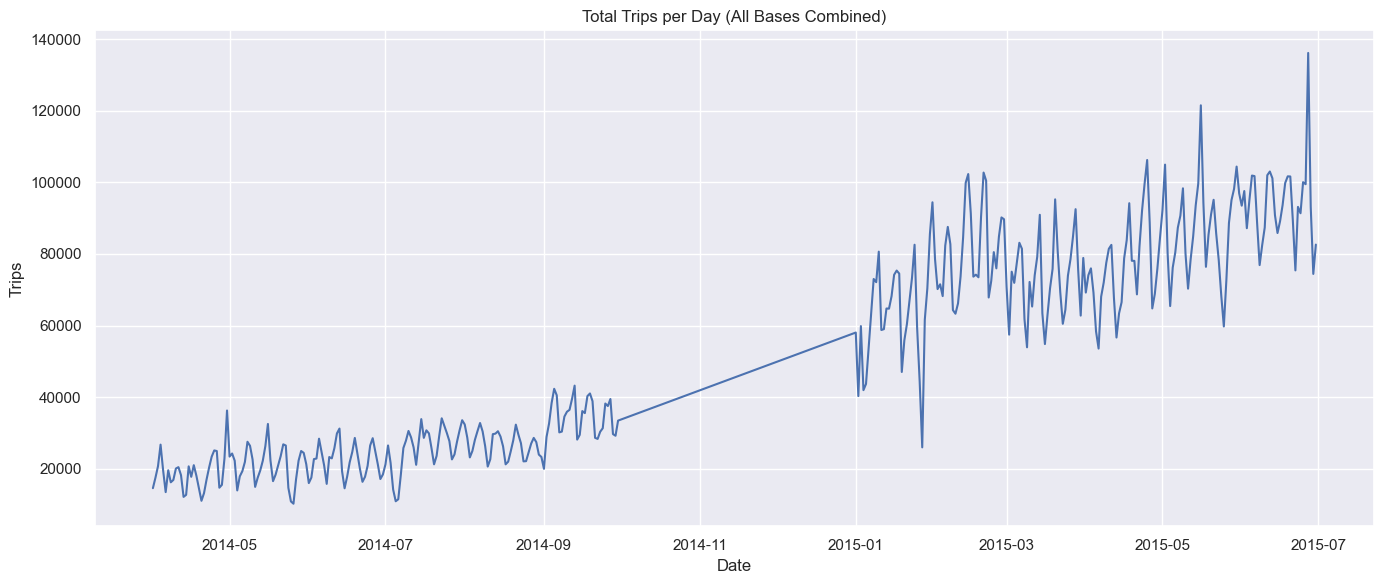

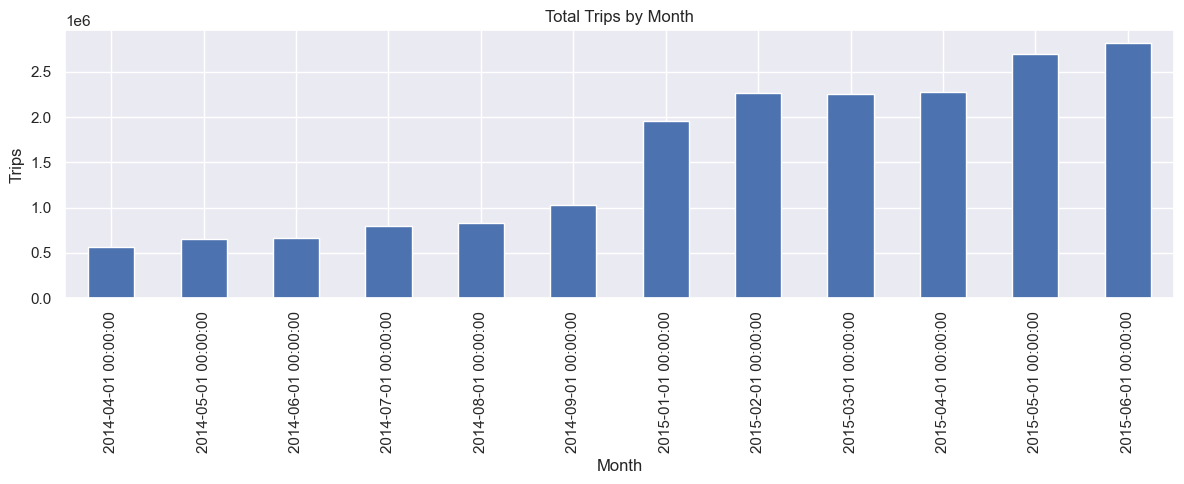

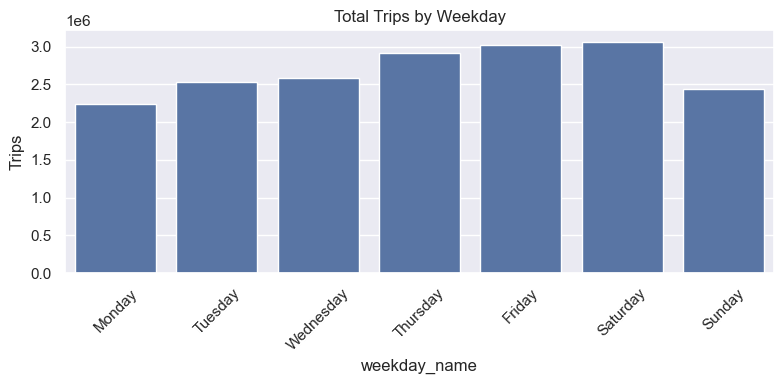

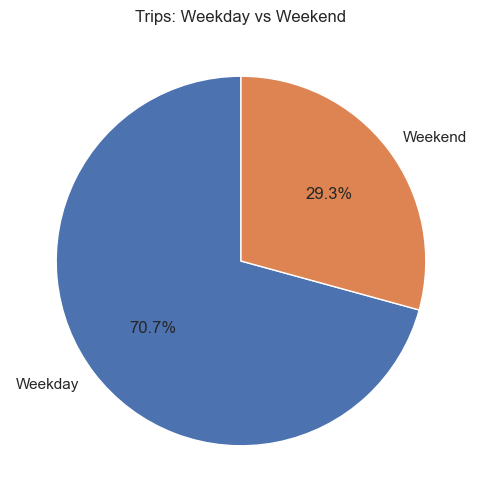

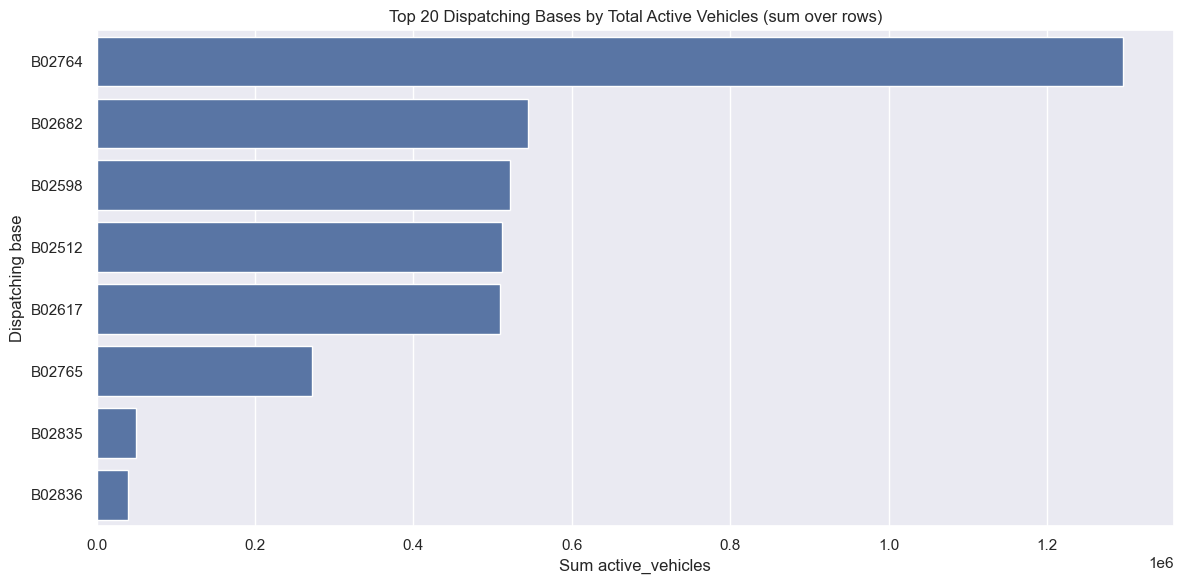

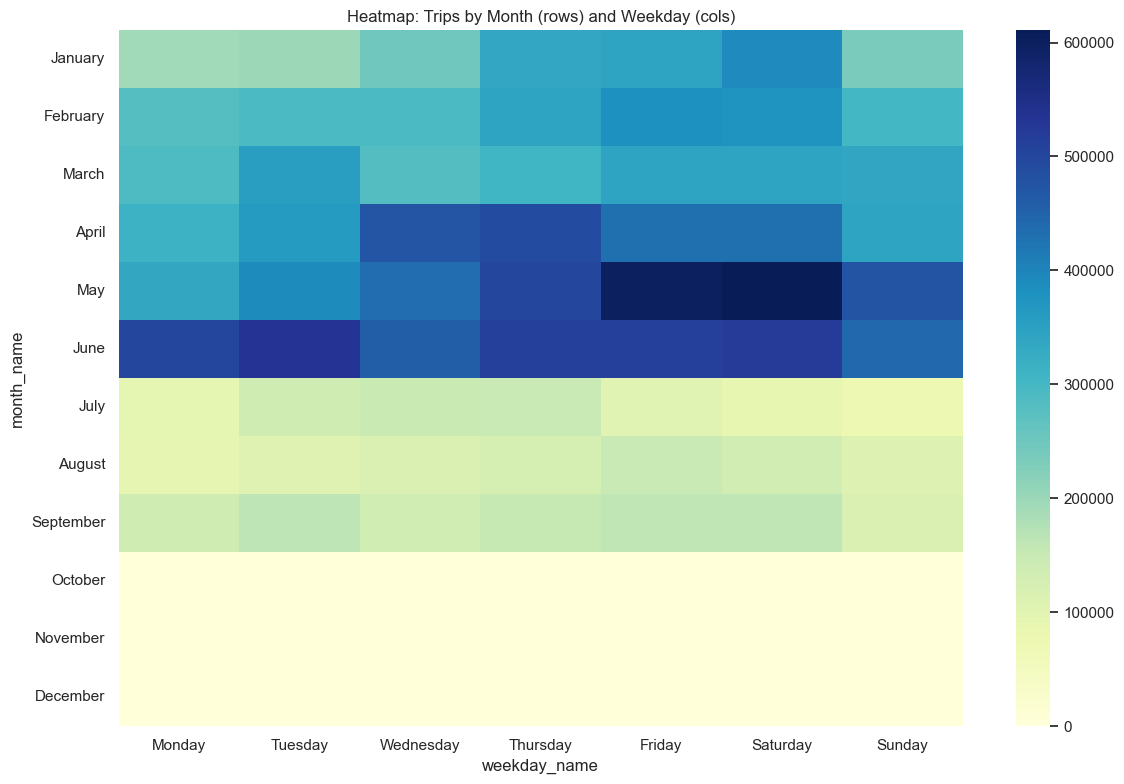

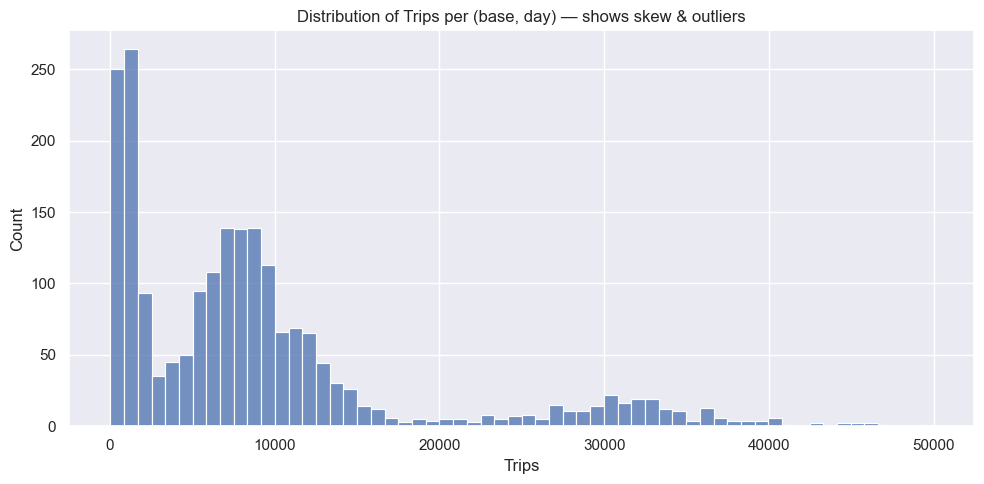


Correlation (trips vs active_vehicles) at (base,date) level: 0.486


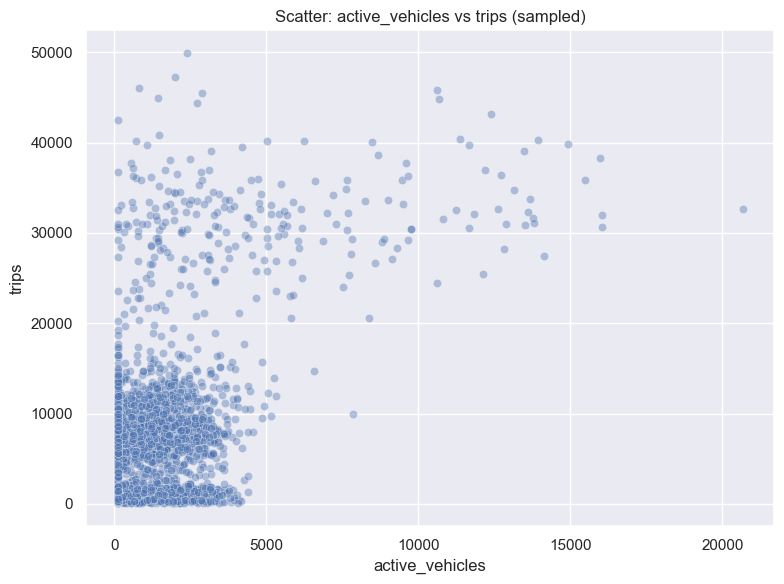

<Figure size 1200x900 with 0 Axes>

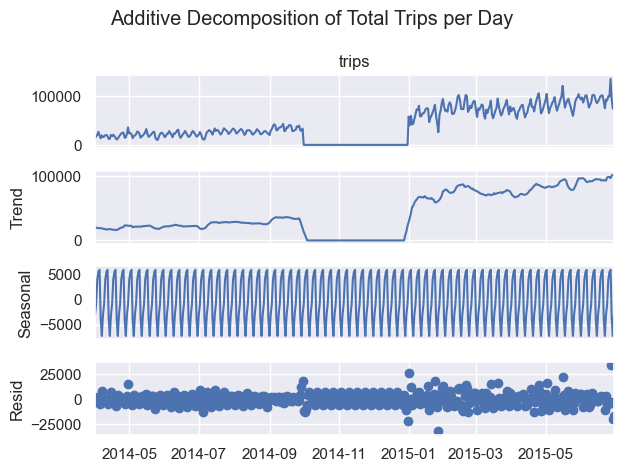


EDA complete. Summary keys: ['total_trips', 'total_active_vehicles', 'total_unique_bases', 'date_min', 'date_max', 'trips_by_month', 'trips_by_day', 'vehicles_by_base', 'trips_by_weekday', 'trips_per_base_stats']


In [2]:
# eda_uber_foil.py
# Run in VS Code / Jupyter. This script reads the dataset and produces summary metrics and plots.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Optional: for time-series decomposition (if installed)
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    has_statsmodels = True
except Exception:
    has_statsmodels = False

plt.rcParams.update({'figure.max_open_warning': 20})
sns.set(style='darkgrid')

# --- Load data ---
path = "Ultimate Merged FOIL.csv"
df = pd.read_csv(path)

# Basic sanity
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample rows:")
print(df.head())

# Ensure column names (handle common casing differences)
expected_cols = ['dispatching_base_number', 'date', 'active_vehicles', 'trips']
cols = df.columns.tolist()
# normalize
df = df.rename(columns={c: c.strip() for c in cols})

# Parse date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
if df['date'].isnull().any():
    print("Warning: some dates could not be parsed. Count:", df['date'].isnull().sum())

# Drop rows with missing key fields
df = df.dropna(subset=['dispatching_base_number', 'date', 'active_vehicles', 'trips'])
df['trips'] = pd.to_numeric(df['trips'], errors='coerce').fillna(0).astype(int)
df['active_vehicles'] = pd.to_numeric(df['active_vehicles'], errors='coerce').fillna(0).astype(int)

# --- Add time features ---
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek  # Mon=0
df['weekday_name'] = df['date'].dt.day_name()
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['week_of_year'] = df['date'].dt.isocalendar().week

# --- Global summary metrics ---
total_trips = df['trips'].sum()
total_active_vehicles = df['active_vehicles'].sum()  # across rows (note: aggregated counting)
total_unique_bases = df['dispatching_base_number'].nunique()
date_min, date_max = df['date'].min(), df['date'].max()

print("\n====== GLOBAL SUMMARY ======")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print(f"Total trips (sum over rows): {total_trips:,}")
print(f"Total active vehicles (sum over rows): {total_active_vehicles:,}")
print(f"Unique dispatching bases: {total_unique_bases:,}")
print("Time span (days):", (date_max - date_min).days)

# --- Aggregations useful for patterns ---
# 1) Total trips by month (across all bases)
trips_by_month = df.groupby(df['date'].dt.to_period('M'))['trips'].sum().sort_index()
trips_by_month.index = trips_by_month.index.to_timestamp()
print("\nTrips by month (top rows):")
print(trips_by_month.head())

# 2) Total trips by day (date)
trips_by_day = df.groupby('date')['trips'].sum().sort_index()

# 3) Total active vehicles per dispatching_base_number (mean and total)
vehicles_by_base = df.groupby('dispatching_base_number')['active_vehicles'].agg(['mean','sum','max','count']).sort_values('sum', ascending=False)
print("\nTop 10 dispatching bases by total active_vehicles:")
print(vehicles_by_base.head(10))

# 4) Trips by weekday
trips_by_weekday = df.groupby('weekday_name')['trips'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# 5) Trips by whether weekend
trips_weekend = df.groupby('is_weekend')['trips'].sum()
print("\nTrips weekday vs weekend:")
print(trips_weekend)

# 6) Trips per base per day (stat distribution)
trips_per_base_day = df.groupby(['dispatching_base_number','date'])['trips'].sum().reset_index()
trips_per_base_stats = trips_per_base_day['trips'].describe()
print("\nTrips per base per day distribution:")
print(trips_per_base_stats)

# --- Visualizations ---
# Set up multi-plot grid
plt.figure(figsize=(14,6))
plt.plot(trips_by_day.index, trips_by_day.values)
plt.title("Total Trips per Day (All Bases Combined)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

# Monthly aggregated bar
plt.figure(figsize=(12,5))
trips_by_month.plot(kind='bar')
plt.title("Total Trips by Month")
plt.xlabel("Month")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

# Weekday bar
plt.figure(figsize=(8,4))
sns.barplot(x=trips_by_weekday.index, y=trips_by_weekday.values)
plt.title("Total Trips by Weekday")
plt.ylabel("Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekend vs Weekday pie
plt.figure(figsize=(6,6))
plt.pie(trips_weekend.values, labels=['Weekday','Weekend'], autopct='%1.1f%%', startangle=90)
plt.title("Trips: Weekday vs Weekend")
plt.show()

# Active vehicles per base (top 20)
top20_bases = vehicles_by_base.reset_index().head(20)
plt.figure(figsize=(12,6))
sns.barplot(y='dispatching_base_number', x='sum', data=top20_bases, orient='h')
plt.title("Top 20 Dispatching Bases by Total Active Vehicles (sum over rows)")
plt.xlabel("Sum active_vehicles")
plt.ylabel("Dispatching base")
plt.tight_layout()
plt.show()

# Heatmap: day-of-week vs hour if you had hour. We don't have hour column; instead create pivot of month vs weekday.
pivot_month_week = df.pivot_table(index='month_name', columns='weekday_name', values='trips', aggfunc='sum').reindex(index=[
    'January','February','March','April','May','June','July','August','September','October','November','December'
], columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(12,8))
sns.heatmap(pivot_month_week.fillna(0), fmt=".0f", cmap='YlGnBu')
plt.title("Heatmap: Trips by Month (rows) and Weekday (cols)")
plt.tight_layout()
plt.show()

# Distribution of trips per base-day
plt.figure(figsize=(10,5))
sns.histplot(trips_per_base_day['trips'], bins=60, kde=False)
plt.title("Distribution of Trips per (base, day) — shows skew & outliers")
plt.xlabel("Trips")
plt.tight_layout()
plt.show()

# Correlation between active vehicles and trips (aggregate per date and base)
agg_base_date = df.groupby(['dispatching_base_number','date'])[['trips','active_vehicles']].sum().reset_index()
corr = agg_base_date[['trips','active_vehicles']].corr().loc['trips','active_vehicles']
print(f"\nCorrelation (trips vs active_vehicles) at (base,date) level: {corr:.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(data=agg_base_date.sample(min(10000, len(agg_base_date)), random_state=42), x='active_vehicles', y='trips', alpha=0.4)
plt.title("Scatter: active_vehicles vs trips (sampled)")
plt.tight_layout()
plt.show()

# Optional: time-series decomposition of total trips per day
if has_statsmodels:
    ts = trips_by_day.asfreq('D').fillna(0)
    decomposition = seasonal_decompose(ts, model='additive', period=7, extrapolate_trend='freq')
    plt.figure(figsize=(12,9))
    decomposition.plot()
    plt.suptitle("Additive Decomposition of Total Trips per Day")
    plt.tight_layout()
    plt.show()
else:
    print("\nstatsmodels not available — skipping seasonal decomposition.")

# --- EDA summary output object for reuse ---
eda_summary = {
    'total_trips': int(total_trips),
    'total_active_vehicles': int(total_active_vehicles),
    'total_unique_bases': int(total_unique_bases),
    'date_min': date_min,
    'date_max': date_max,
    'trips_by_month': trips_by_month,
    'trips_by_day': trips_by_day,
    'vehicles_by_base': vehicles_by_base,
    'trips_by_weekday': trips_by_weekday,
    'trips_per_base_stats': trips_per_base_stats,
}
print("\nEDA complete. Summary keys:", list(eda_summary.keys()))


Modeling dataset shape: (335, 20)
Train size: (268, 19), Test size: (67, 19)

Training RandomForest...
RandomForest — MAE: 7370.14, RMSE: 10113.25

Training GradientBoosting...
GradientBoosting — MAE: 8480.73, RMSE: 10952.12

Selected best model: RandomForest


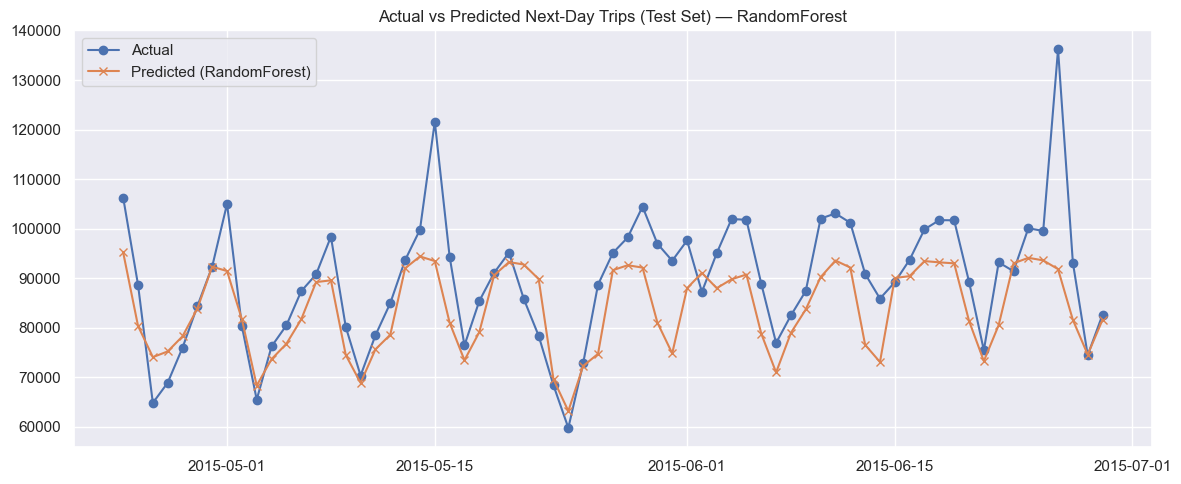


Top 20 feature importances:
trips                  0.300507
trips_roll_14          0.275165
trips_roll_7           0.206190
trips_lag_1            0.103066
year                   0.029931
weekofyear             0.013578
weekday                0.011665
dayofweek              0.011482
trips_lag_3            0.007656
trips_lag_7            0.007168
is_weekend             0.006503
trips_lag_28           0.005758
day                    0.005121
trips_lag_14           0.004599
trips_lag_2            0.003336
active_vehicles_sum    0.003078
active_veh_roll_7      0.003073
month                  0.001794
quarter                0.000331
dtype: float64


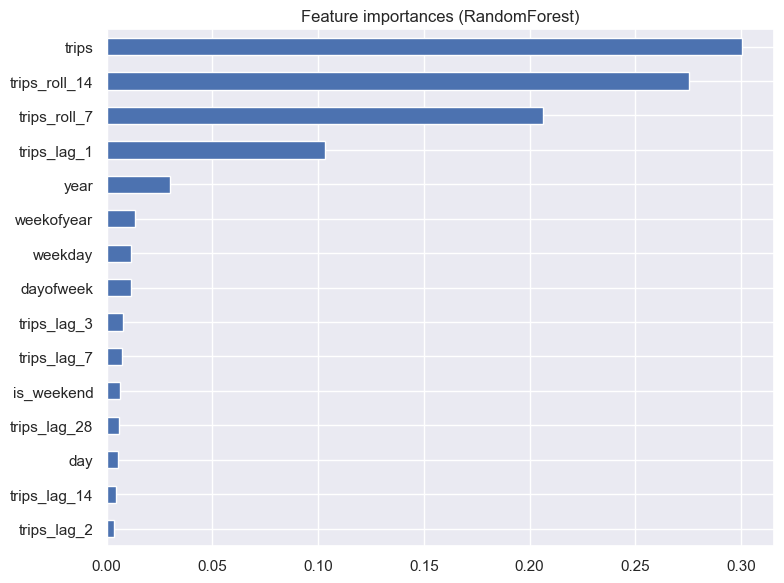

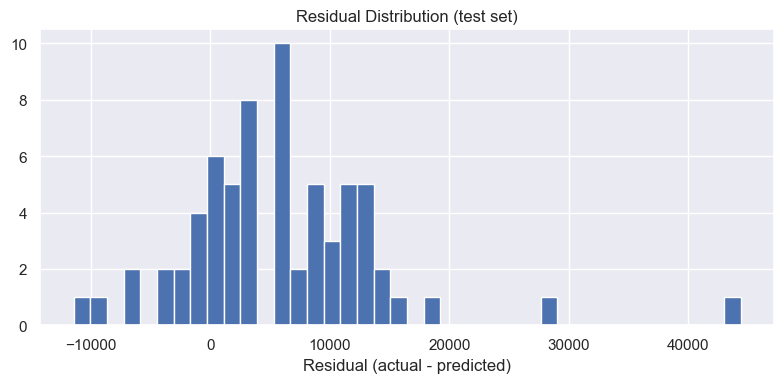


Next 14-day forecast (total trips per day):
2015-07-01    57231.415
2015-07-02    54357.650
2015-07-03    54738.215
2015-07-04    49318.440
2015-07-05    48930.790
2015-07-06    56404.085
2015-07-07    55838.950
2015-07-08    54681.165
2015-07-09    54156.830
2015-07-10    52844.065
2015-07-11    49388.220
2015-07-12    49054.540
2015-07-13    53957.865
2015-07-14    53796.545
Name: trips, dtype: float64


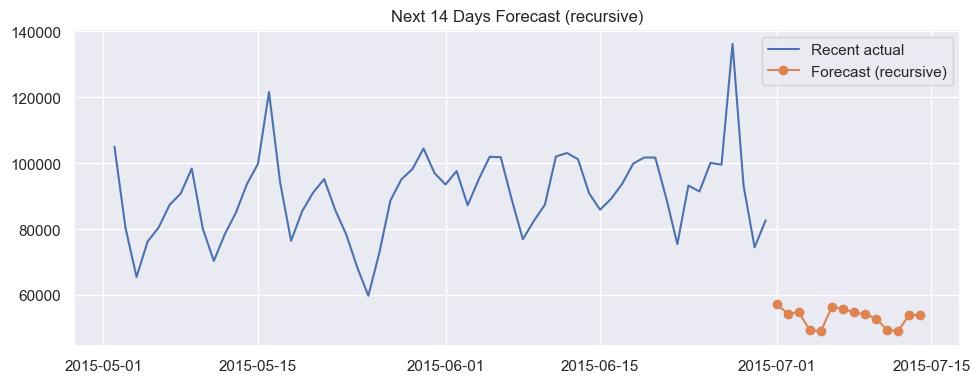


Modeling complete. Best model: RandomForest


In [4]:
# model_trip_demand.py
# Aggregates to daily total trips, engineers time features & lags, trains models and evaluates.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import joblib

# Load dataset
path = "Ultimate Merged FOIL.csv"
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date','trips'])
df['trips'] = pd.to_numeric(df['trips'], errors='coerce').fillna(0).astype(int)

# Aggregate to daily total trips (city-level)
daily = df.groupby('date')['trips'].sum().sort_index().to_frame()
daily['active_vehicles_sum'] = df.groupby('date')['active_vehicles'].sum().sort_index()
daily = daily.fillna(0)

# Time features
daily['dayofweek'] = daily.index.dayofweek
daily['weekday'] = daily.index.weekday
daily['is_weekend'] = daily['dayofweek'].isin([5,6]).astype(int)
daily['day'] = daily.index.day
daily['month'] = daily.index.month
daily['quarter'] = daily.index.quarter
daily['weekofyear'] = daily.index.isocalendar().week.astype(int)
daily['year'] = daily.index.year

# Lags and rolling features
def add_lags(df_, col='trips', lags=[1,2,3,7,14]):
    for l in lags:
        df_[f'{col}_lag_{l}'] = df_[col].shift(l)
    return df_

daily = add_lags(daily, 'trips', lags=[1,2,3,7,14,28])
# rolling means
daily['trips_roll_7'] = daily['trips'].shift(1).rolling(window=7, min_periods=1).mean()
daily['trips_roll_14'] = daily['trips'].shift(1).rolling(window=14, min_periods=1).mean()
daily['active_veh_roll_7'] = daily['active_vehicles_sum'].shift(1).rolling(7, min_periods=1).mean()

# Target: predict next-day trips
daily['target_tomorrow'] = daily['trips'].shift(-1)
# Drop rows with NaNs introduced by shifting
data = daily.dropna().copy()
print("Modeling dataset shape:", data.shape)

# Features & target
features = [c for c in data.columns if c not in ['target_tomorrow']]
X = data[features]
y = data['target_tomorrow']

# Time-series split: train on earlier dates, test on last chunk
split_index = int(len(data)*0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# Model definitions
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Fit and evaluate function
def fit_and_eval(model, Xtr, ytr, Xte, yte, name="model"):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    mae = mean_absolute_error(yte, preds)
    rmse = np.sqrt(mean_squared_error(yte, preds))
    print(f"{name} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return model, preds, mae, rmse

print("\nTraining RandomForest...")
rf_model, rf_preds, rf_mae, rf_rmse = fit_and_eval(rf, X_train, y_train, X_test, y_test, "RandomForest")

print("\nTraining GradientBoosting...")
gb_model, gb_preds, gb_mae, gb_rmse = fit_and_eval(gb, X_train, y_train, X_test, y_test, "GradientBoosting")

# Compare
if rf_rmse < gb_rmse:
    best_model, best_name = rf_model, "RandomForest"
    best_preds = rf_preds
else:
    best_model, best_name = gb_model, "GradientBoosting"
    best_preds = gb_preds
print(f"\nSelected best model: {best_name}")

# Plot actual vs predicted on test set
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, best_preds, label=f'Predicted ({best_name})', marker='x')
plt.title(f"Actual vs Predicted Next-Day Trips (Test Set) — {best_name}")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importances
if hasattr(best_model, 'feature_importances_'):
    fi = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 20 feature importances:")
    print(fi.head(20))
    plt.figure(figsize=(8,6))
    fi.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Feature importances ({best_name})")
    plt.tight_layout()
    plt.show()
else:
    print("Model has no feature_importances_ attribute.")

# Residual analysis
residuals = y_test.values - best_preds
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.title("Residual Distribution (test set)")
plt.xlabel("Residual (actual - predicted)")
plt.tight_layout()
plt.show()

# --- Recursive multi-day forecast example (forecast next 14 days) ---
# We'll forecast day-by-day using the model and created features.
last_known = daily.iloc[-60:].copy()  # keep recent history for features
future_steps = 14
future_index = pd.date_range(start=daily.index.max() + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_df = pd.DataFrame(index=future_index)

# initialize a df that includes past history and future placeholders
combined = pd.concat([daily, future_df], axis=0)
combined = combined.sort_index()

# We'll fill future rows iteratively using the model
for i in range(1, future_steps+1):
    cur_date = daily.index.max() + pd.Timedelta(days=i)
    # compute features for cur_date based on previous values
    # compute lags (e.g., trips_lag_1 is trips at cur_date-1)
    for lag in [1,2,3,7,14,28]:
        lag_date = cur_date - pd.Timedelta(days=lag)
        combined.at[cur_date, f'trips_lag_{lag}'] = combined.at[lag_date, 'trips'] if lag_date in combined.index else np.nan
    # rolling features
    # trips_roll_7: mean of previous 7 days (exclude current)
    prev_window = combined.loc[cur_date - pd.Timedelta(days=7): cur_date - pd.Timedelta(days=1), 'trips']
    combined.at[cur_date, 'trips_roll_7'] = prev_window.mean() if len(prev_window)>0 else np.nan
    prev_window14 = combined.loc[cur_date - pd.Timedelta(days=14): cur_date - pd.Timedelta(days=1), 'trips']
    combined.at[cur_date, 'trips_roll_14'] = prev_window14.mean() if len(prev_window14)>0 else np.nan
    # active vehicles features: we don't have future active vehicles, so use last known or rolling mean
    combined.at[cur_date, 'active_vehicles_sum'] = combined['active_vehicles_sum'].ffill().iloc[-1]
    combined.at[cur_date, 'active_veh_roll_7'] = combined['active_vehicles_sum'].shift(1).rolling(7, min_periods=1).mean().loc[cur_date]
    # time features
    combined.at[cur_date, 'dayofweek'] = cur_date.dayofweek
    combined.at[cur_date, 'weekday'] = cur_date.weekday()
    combined.at[cur_date, 'is_weekend'] = int(cur_date.dayofweek in [5,6])
    combined.at[cur_date, 'day'] = cur_date.day
    combined.at[cur_date, 'month'] = cur_date.month
    combined.at[cur_date, 'quarter'] = cur_date.quarter
    combined.at[cur_date, 'weekofyear'] = cur_date.isocalendar()[1]
    combined.at[cur_date, 'year'] = cur_date.year

    # Check columns for model
    row_features = combined.loc[cur_date, features]
    if row_features.isnull().any():
        # simple fill for NaNs: forward fill or zero
        row_features = row_features.fillna(method='ffill').fillna(0)

    pred = best_model.predict(row_features.values.reshape(1, -1))[0]
    combined.at[cur_date, 'trips'] = pred  # use predicted trips as input for subsequent steps

future_forecast = combined.loc[future_index, 'trips']
print("\nNext 14-day forecast (total trips per day):")
print(future_forecast)

plt.figure(figsize=(10,4))
plt.plot(daily.index[-60:], daily['trips'].iloc[-60:], label='Recent actual')
plt.plot(future_forecast.index, future_forecast.values, label='Forecast (recursive)', marker='o')
plt.title("Next 14 Days Forecast (recursive)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nModeling complete. Best model:", best_name)


In [17]:
# app_dash_uber_advanced.py
# Dash dashboard that performs EDA visualizations and provides an improved 1-month forecast.
# Reads: /mnt/data/Ultimate Merged FOIL.csv
# Run: python app_dash_uber_advanced.py
# Notes: tries Prophet first (best for seasonality). Falls back to LightGBM, then to sklearn gradient boosting.

import pandas as pd
import numpy as np
from datetime import timedelta
import math

import plotly.express as px
import plotly.graph_objects as go

import dash
from dash import html, dcc, dash_table
from dash.dependencies import Input, Output

# Modeling imports - attempted in order of preference
Prophet = None
try:
    from prophet import Prophet  # modern prophet
    Prophet = Prophet
except Exception:
    try:
        from fbprophet import Prophet  # legacy name
        Prophet = Prophet
    except Exception:
        Prophet = None

LGB_AVAILABLE = False
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------
# Load & preprocess data
# -----------------------
PATH = "Ultimate Merged FOIL.csv"
df = pd.read_csv(PATH)
# Normalize column names
df.columns = [c.strip() for c in df.columns]
# Parse dates and coerce types
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['trips'] = pd.to_numeric(df['trips'], errors='coerce').fillna(0).astype(int)
df['active_vehicles'] = pd.to_numeric(df.get('active_vehicles', 0), errors='coerce').fillna(0).astype(int)
df['dispatching_base_number'] = df['dispatching_base_number'].astype(str)

# Aggregate to daily level (city-level)
daily = df.groupby('date').agg({'trips': 'sum', 'active_vehicles': 'sum'}).sort_index()
daily = daily.asfreq('D', fill_value=0)

# Basic EDA aggregates
total_trips = int(daily['trips'].sum())
avg_trips_per_day = float(daily['trips'].mean())
total_active_vehicles_sum = int(daily['active_vehicles'].sum())
total_bases = int(df['dispatching_base_number'].nunique())
date_min, date_max = daily.index.min(), daily.index.max()

# Monthly & weekday aggregates
trips_by_month = df.groupby(df['date'].dt.to_period('M'))['trips'].sum()
trips_by_month.index = trips_by_month.index.to_timestamp()
trips_by_month = trips_by_month.sort_index()

trips_by_weekday = df.groupby(df['date'].dt.day_name())['trips'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index().rename(columns={'date':'weekday','trips':'trips'}).rename(columns={'index':'weekday'})

# Weekend vs weekday
df['is_weekend'] = df['date'].dt.dayofweek.isin([5,6])
trips_weekend = df.groupby(df['is_weekend'])['trips'].sum().reindex([False, True]).fillna(0)
weekday_vs_weekend = pd.DataFrame({
    'label': ['Weekday','Weekend'],
    'trips': [int(trips_weekend.loc[False]), int(trips_weekend.loc[True])]
})

# Base-level aggregates (top N)
bases_agg = df.groupby('dispatching_base_number').agg({
    'trips': 'sum',
    'active_vehicles': 'sum'
}).sort_values('trips', ascending=False).reset_index()
top_bases = bases_agg.head(20)

# -----------------------
# Forecasting (improved)
# -----------------------
HOLDOUT_DAYS = 30               # used for validation
FORECAST_DAYS = 30              # 1 month forecast to display on dashboard

def evaluate_and_forecast_prophet(daily_series, holdout_days=HOLDOUT_DAYS, fut_days=FORECAST_DAYS):
    # prepare dataframe for Prophet
    dfp = daily_series.reset_index().rename(columns={'date':'ds','trips':'y'})
    # split train/test
    train = dfp.iloc[:-holdout_days]
    test = dfp.iloc[-holdout_days:]
    m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
    # add a monthly seasonality to capture monthly patterns
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(train)
    # predict validation
    future_val = m.make_future_dataframe(periods=holdout_days, freq='D')
    forecast_val = m.predict(future_val)
    # isolate holdout period predictions
    pred_val = forecast_val.set_index('ds').loc[test['ds'], ['yhat','yhat_lower','yhat_upper']]
    mae = mean_absolute_error(test['y'].values, pred_val['yhat'].values)
    rmse = math.sqrt(mean_squared_error(test['y'].values, pred_val['yhat'].values))
    # Refit on full data and predict future
    m_full = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
    m_full.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m_full.fit(dfp)
    future_full = m_full.make_future_dataframe(periods=fut_days, freq='D')
    forecast_full = m_full.predict(future_full).set_index('ds').iloc[-fut_days:][['yhat','yhat_lower','yhat_upper']]
    return {
        'model': 'prophet',
        'mae': mae, 'rmse': rmse,
        'val_pred': pred_val,
        'forecast': forecast_full
    }

def create_features_for_lgb(series):
    s = series.copy().to_frame('trips')
    s['dayofweek'] = s.index.dayofweek
    s['month'] = s.index.month
    s['is_weekend'] = s['dayofweek'].isin([5,6]).astype(int)
    for lag in [1,2,3,7,14,28]:
        s[f'lag_{lag}'] = s['trips'].shift(lag)
    s['roll_7'] = s['trips'].shift(1).rolling(7, min_periods=1).mean()
    s['roll_14'] = s['trips'].shift(1).rolling(14, min_periods=1).mean()
    s['roll_28'] = s['trips'].shift(1).rolling(28, min_periods=1).mean()
    s = s.dropna()
    return s

def evaluate_and_forecast_lgb(daily_series, holdout_days=HOLDOUT_DAYS, fut_days=FORECAST_DAYS):
    feat = create_features_for_lgb(daily_series)
    # align dates for features and targets
    X = feat.drop(columns=['trips'])
    y = feat['trips']
    train_idx = slice(None, -holdout_days-1) if holdout_days < len(X) else slice(0, int(len(X)*0.8))
    X_train, X_val = X.iloc[: -holdout_days], X.iloc[-holdout_days:]
    y_train, y_val = y.iloc[: -holdout_days], y.iloc[-holdout_days:]
    # fallback if slicing produces empty
    if len(X_train) < 10:
        X_train, y_train = X.iloc[:-holdout_days*2], y.iloc[:-holdout_days*2]
        X_val, y_val = X.iloc[-holdout_days*2:-holdout_days], y.iloc[-holdout_days*2:-holdout_days]
    if LGB_AVAILABLE:
        model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
    else:
        model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False) if LGB_AVAILABLE else model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred_val)
    rmse = math.sqrt(mean_squared_error(y_val, pred_val))
    # multi-step recursive forecast
    last_known = daily_series.copy()
    future_dates = pd.date_range(start=last_known.index.max() + timedelta(days=1), periods=fut_days)
    preds = []
    temp = last_known.copy()
    for d in future_dates:
        # compute features for this date from temp
        row = {}
        row['dayofweek'] = d.dayofweek
        row['month'] = d.month
        row['is_weekend'] = int(d.dayofweek in [5,6])
        for lag in [1,2,3,7,14,28]:
            ref = d - timedelta(days=lag)
            row[f'lag_{lag}'] = temp['trips'].get(ref, temp['trips'].iloc[-1])
        # rolling
        prev7 = [temp['trips'].get(d - timedelta(days=i), temp['trips'].iloc[-1]) for i in range(1,8)]
        prev14 = [temp['trips'].get(d - timedelta(days=i), temp['trips'].iloc[-1]) for i in range(1,15)]
        prev28 = [temp['trips'].get(d - timedelta(days=i), temp['trips'].iloc[-1]) for i in range(1,29)]
        row['roll_7'] = np.mean(prev7)
        row['roll_14'] = np.mean(prev14)
        row['roll_28'] = np.mean(prev28)
        Xrow = pd.DataFrame([row])
        pred = model.predict(Xrow)[0]
        preds.append(pred)
        temp.at[d, 'trips'] = pred  # append predicted to temp for next iteration
    forecast_index = future_dates
    forecast_df = pd.DataFrame(index=forecast_index, data={'yhat': preds})
    # create uncertainty bands from residuals on validation set
    residuals = y_val.values - pred_val
    sigma = np.std(residuals)
    forecast_df['yhat_lower'] = forecast_df['yhat'] - 1.96 * sigma
    forecast_df['yhat_upper'] = forecast_df['yhat'] + 1.96 * sigma
    return {
        'model': 'lightgbm' if LGB_AVAILABLE else 'gbr',
        'mae': mae, 'rmse': rmse,
        'val_pred': pd.DataFrame({'yhat': pred_val}, index=X_val.index),
        'forecast': forecast_df
    }

# Try Prophet first, then LightGBM/GBR
forecast_result = None
try:
    if Prophet is not None:
        forecast_result = evaluate_and_forecast_prophet(daily['trips'])
    else:
        raise Exception("Prophet not available")
except Exception:
    try:
        forecast_result = evaluate_and_forecast_lgb(daily['trips'])
    except Exception:
        # as last resort, simple rolling avg forecast with uncertainty from historical std
        recent_avg = daily['trips'].rolling(7, min_periods=1).mean().iloc[-1]
        future_idx = pd.date_range(daily.index.max()+timedelta(days=1), periods=FORECAST_DAYS)
        forecast_df = pd.DataFrame(index=future_idx)
        forecast_df['yhat'] = recent_avg
        sigma = daily['trips'].diff().std()
        forecast_df['yhat_lower'] = forecast_df['yhat'] - 1.96 * sigma
        forecast_df['yhat_upper'] = forecast_df['yhat'] + 1.96 * sigma
        forecast_result = {
            'model': 'rolling_avg',
            'mae': None, 'rmse': None,
            'val_pred': None,
            'forecast': forecast_df
        }

# Forecast metrics for dashboard cards
forecast_df = forecast_result['forecast']
forecast_total_30 = int(np.round(forecast_df['yhat'].sum()))
forecast_avg_daily = float(np.round(forecast_df['yhat'].mean(), 2))
prev_30_total = int(daily['trips'].tail(30).sum()) if len(daily) >= 30 else int(daily['trips'].sum())
pct_change_vs_prev30 = float(np.round((forecast_total_30 - prev_30_total) / prev_30_total * 100, 2)) if prev_30_total > 0 else None
peak_day = forecast_df['yhat'].idxmax().date()
peak_value = int(np.round(forecast_df['yhat'].max()))

# -----------------------
# Plotly Figures setup
# -----------------------
from prophet import Prophet

# Color scheme
BG = "#0f1724"
CARD_BG = "#0b1220"
ACCENT = "#00a6fb"
TEXT = "#e6f0f8"
SECOND = "#94a3b8"

def apply_dark(fig):
    fig.update_layout(template='plotly_dark',
                      plot_bgcolor=BG,
                      paper_bgcolor=BG,
                      font=dict(color=TEXT))
    return fig

# -----------------------
# Forecast with Prophet
# -----------------------
ts = df.groupby('date')['trips'].sum().reset_index()
ts.columns = ['ds','y']

m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m.fit(ts)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Prophet Forecast - 30 days ahead with shaded bounds
fig_forecast = go.Figure()
fig_forecast.add_trace(go.Scatter(x=ts['ds'], y=ts['y'],
                                  mode='lines', name='Actual',
                                  line=dict(width=2)))

fig_forecast.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],
                                  mode='lines+markers', name='Forecast',
                                  line=dict(color=ACCENT, width=3)))

# Shaded confidence interval (upper/lower bounds)
fig_forecast.add_trace(go.Scatter(
    x=list(forecast['ds']) + list(forecast['ds'][::-1]),
    y=list(forecast['yhat_upper']) + list(forecast['yhat_lower'][::-1]),
    fill='toself',
    fillcolor='rgba(0,166,251,0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False,
    name='Uncertainty'
))

fig_forecast.update_layout(
    title="Trips Forecast (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Trips"
)
fig_forecast = apply_dark(fig_forecast)

# Summary metrics from Prophet forecast
forecast_total_30 = int(forecast_df['yhat'].sum())
forecast_avg_daily = int(forecast_df['yhat'].mean())
peak_idx = forecast_df['yhat'].idxmax()
peak_value = int(forecast_df.loc[peak_idx, 'yhat'])
peak_day = peak_idx.date()

forecast_result = {
    'model': 'Prophet',
    'mae': None  # could compute from a validation split if desired
}

# -----------------------
# Main time-series with forecast overlay
# -----------------------
fig_main = go.Figure()
fig_main.add_trace(go.Scatter(x=daily.index, y=daily['trips'],
                              mode='lines', name='Actual trips', line=dict(width=2)))

# Prophet forecast (30d)
fig_main.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['yhat'],
                              mode='lines+markers', name='Forecast (30d)',
                              line=dict(color=ACCENT, width=3)))
# Uncertainty band
fig_main.add_trace(go.Scatter(
    x=list(forecast_df.index) + list(forecast_df.index[::-1]),
    y=list(forecast_df['yhat_upper']) + list(forecast_df['yhat_lower'][::-1]),
    fill='toself',
    fillcolor='rgba(0,166,251,0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False,
    name='Uncertainty'
))
fig_main.update_layout(title="Total Trips per Day — Actual + 30-day Forecast",
                       xaxis_title="Date", yaxis_title="Trips")
fig_main = apply_dark(fig_main)

# -----------------------
# Monthly bar
# -----------------------
fig_month = px.bar(x=trips_by_month.index, y=trips_by_month.values,
                   labels={'x':'Month','y':'Trips'},
                   title="Total Trips by Month")
fig_month = apply_dark(fig_month)

# -----------------------
# Weekday bar
# -----------------------
weekday_df = df.groupby(df['date'].dt.day_name())['trips'].sum()\
               .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
               .reset_index()
fig_weekday = px.bar(weekday_df, x='date', y='trips',
                     labels={'date':'Weekday','trips':'Trips'},
                     title="Total Trips by Weekday")
fig_weekday = apply_dark(fig_weekday)

# -----------------------
# Weekend pie
# -----------------------
fig_weekend = px.pie(weekday_vs_weekend, names='label', values='trips',
                     title='Weekday vs Weekend share')
fig_weekend = apply_dark(fig_weekend)

# -----------------------
# Top bases - trips
# -----------------------
fig_top_bases_trips = px.bar(top_bases.head(20), x='dispatching_base_number', y='trips',
                             title='Top 20 Bases by Trips')
fig_top_bases_trips = apply_dark(fig_top_bases_trips)

# -----------------------
# Top bases - active vehicles
# -----------------------
top_active = df.groupby('dispatching_base_number')['active_vehicles']\
               .sum().reset_index()\
               .sort_values('active_vehicles', ascending=False).head(20)
fig_top_bases_active = px.bar(top_active, x='dispatching_base_number', y='active_vehicles',
                              title='Top 20 Bases by Sum Active Vehicles')
fig_top_bases_active = apply_dark(fig_top_bases_active)

# -----------------------
# Per-base options for dropdown
# -----------------------
base_options = [{'label': b, 'value': b} for b in sorted(df['dispatching_base_number'].unique())]

# -----------------------
# Table data for top bases
# -----------------------
table_df = top_bases.rename(columns={'dispatching_base_number':'base',
                                     'trips':'trips_total',
                                     'active_vehicles':'active_total'})
table_df['trips_total'] = table_df['trips_total'].astype(int)
table_df['active_total'] = table_df['active_total'].astype(int)

# -----------------------
# Dash Layout
# -----------------------
app = dash.Dash(__name__, suppress_callback_exceptions=True)
app.title = "Uber Trip Demand — Dashboard"

def kpi_card(title, value, subtitle=""):
    return html.Div([
        html.Div(title, style={'fontSize':14, 'color':SECOND}),
        html.Div(value, style={'fontSize':24, 'fontWeight':'700', 'color':TEXT}),
        html.Div(subtitle, style={'fontSize':12, 'color':SECOND})
    ], style={
        'flex':'1',
        'minWidth':'200px',
        'padding':'12px',
        'background':CARD_BG,
        'borderRadius':'10px',
        'textAlign':'center',
        'margin':'6px'
    })

app.layout = html.Div(
    style={'padding':'18px','backgroundColor':BG,'minHeight':'100vh','fontFamily':'Inter, Arial'},
    children=[
        # Header
        html.Div([
            html.H1("Uber Trip Analysis", style={'textAlign':'center','color':ACCENT,'marginBottom':4}),
            html.Div(f"Data range: {date_min.date()} → {date_max.date()}",
                     style={'color':SECOND,'textAlign':'center','marginBottom':10})
        ]),

        # KPI Row
        html.Div([
            kpi_card("Total Trips (dataset)", f"{total_trips:,}", "Sum across all dates & bases"),
            kpi_card("Avg Trips / Day", f"{avg_trips_per_day:,.1f}", "Daily average"),
            kpi_card("Total Active Vehicles (sum)", f"{total_active_vehicles_sum:,}", "Sum across rows"),
            kpi_card("Unique Dispatching Bases", f"{total_bases:,}", "")
        ], style={'display':'flex','flexWrap':'wrap','justifyContent':'space-between','marginBottom':'20px'}),

        # Main time series (actual trips only, no forecast here)
        html.Div([
            dcc.Graph(figure=fig_main, style={'width':'100%'})
        ], style={'marginBottom':'28px'}),

        # Monthly + Weekday
        html.Div([
            html.Div(dcc.Graph(figure=fig_month, style={'minHeight':'400px','maxHeight':'500px'}),
                     style={'flex':'1','margin':'6px'}),
            html.Div(dcc.Graph(figure=fig_weekday, style={'minHeight':'400px','maxHeight':'500px'}),
                     style={'flex':'1','margin':'6px'})
        ], style={'display':'flex','flexWrap':'wrap','marginBottom':'20px'}),

        # Weekend + Active Vehicles by Base
        html.Div([
            html.Div(dcc.Graph(figure=fig_weekend, style={'minHeight':'400px','maxHeight':'500px'}),
                     style={'flex':'1','margin':'6px','minWidth':'300px'}),
            html.Div(dcc.Graph(figure=fig_top_bases_active, style={'minHeight':'400px','maxHeight':'500px'}),
                     style={'flex':'2','margin':'6px'})
        ], style={'display':'flex','flexWrap':'wrap','marginBottom':'20px'}),

        # Top bases + interactive base selector
        html.Div([
            html.Div(
                dcc.Graph(figure=fig_top_bases_trips,
                        style={'minHeight':'400px','maxHeight':'500px'}),
                style={'flex':'1','margin':'6px'}
            ),
            html.Div([
                html.Label("Select a Dispatching Base:", style={'color':TEXT}),
                dcc.Dropdown(
                    id='base-dropdown',
                    options=base_options,
                    value=base_options[0]['value'],
                    clearable=False,
                    style={'marginBottom':10}
                ),
                dcc.Graph(id='base-timeseries',
                        style={'minHeight':'400px','maxHeight':'500px'})
            ], style={'flex':'1','margin':'6px','minWidth':'400px'})
        ], style={'display':'flex','flexWrap':'wrap','marginBottom':'20px'}),

        # Top bases table (without weekday breakdown)
        html.Div([
            html.H3("Top Dispatching Bases (summary)", style={'color':TEXT}),
            dash_table.DataTable(
                id='bases-table',
                columns=[
                    {'name':'Base','id':'base'},
                    {'name':'Trips (total)','id':'trips_total','type':'numeric','format':{'specifier':','}},
                    {'name':'Active Vehicles (total)','id':'active_total','type':'numeric','format':{'specifier':','}}
                ],
                data=table_df.to_dict('records'),
                style_table={'overflowX':'auto'},
                style_header={'backgroundColor':CARD_BG,'color':TEXT,'fontWeight':'600'},
                style_cell={'backgroundColor':BG,'color':TEXT,'padding':'8px','textAlign':'left'},
                page_size=10
            )
        ], style={'paddingTop':8,'paddingBottom':40}),

        # Forecast Visualization (bottom section)
        html.Div([
            html.H3("Forecast — Trips Next 30 Days", style={'color':ACCENT,'textAlign':'center'}),
            dcc.Graph(figure=fig_forecast, style={'width':'100%','minHeight':'450px'}),
            html.Div([
                html.H3("30-Day Forecast Summary", style={'color':TEXT,'marginBottom':10,'textAlign':'center'}),
                html.Div([
                    html.Div([
                        html.Div("Forecasted total (30d)", style={'color':SECOND}),
                        html.Div(f"{forecast_total_30:,}", style={'fontSize':18,'color':TEXT,'fontWeight':'700'})
                    ], style={'flex':'1','background':CARD_BG,'padding':'10px','borderRadius':8,'margin':'6px','textAlign':'center'}),
                    html.Div([
                        html.Div("Avg daily (30d)", style={'color':SECOND}),
                        html.Div(f"{forecast_avg_daily:,.0f}", style={'fontSize':18,'color':TEXT,'fontWeight':'700'})
                    ], style={'flex':'1','background':CARD_BG,'padding':'10px','borderRadius':8,'margin':'6px','textAlign':'center'})
                ], style={'display':'flex','flexWrap':'wrap','justifyContent':'center'}),
                html.Div([
                    html.Div(f"Change vs prev 30d: {pct_change_vs_prev30:+}%",
                             style={'color':ACCENT if pct_change_vs_prev30 and pct_change_vs_prev30>0 else TEXT,
                                    'fontWeight':'600','textAlign':'center'}),
                    html.Div(f"Peak forecast day: {peak_day} ({peak_value:,} trips)",
                             style={'color':SECOND,'marginTop':6,'textAlign':'center'}),
                    html.Div(f"Forecast model: {forecast_result.get('model','N/A')}, val MAE: {round(forecast_result.get('mae'),2) if forecast_result.get('mae') is not None else 'N/A'}",
                             style={'color':SECOND,'marginTop':6,'textAlign':'center'})
                ], style={'marginTop':10})
            ], style={'background':CARD_BG,'borderRadius':10,'padding':'14px','maxWidth':'700px','margin':'20px auto'})
        ], style={'marginBottom':'30px'}),

        # Footer
        html.Div(
            f"Dashboard generated using model: {forecast_result.get('model','N/A')}. For best results, run the full modeling notebook to tune models and add exogenous features (events, holidays, weather).",
            style={'color':SECOND,'fontSize':12,'textAlign':'center','paddingTop':6}
        )
    ]
)

# -----------------------
# Callbacks
# -----------------------
@app.callback(
    Output('base-timeseries', 'figure'),
    [Input('base-dropdown', 'value')]
)
def update_base_timeseries(selected_base):
    sub = df[df['dispatching_base_number'] == str(selected_base)].groupby('date')['trips'].sum().sort_index()
    if len(sub) == 0:
        fig = go.Figure()
        fig.add_annotation(text="No data for selected base", showarrow=False)
        return apply_dark(fig)
    sub = sub.asfreq('D', fill_value=0)
    # simple rolling to show trend
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sub.index, y=sub.values, mode='lines', name='Trips'))
    fig.add_trace(go.Scatter(x=sub.index, y=sub.rolling(7, min_periods=1).mean().values, mode='lines', name='7d MA', line=dict(dash='dash')))
    fig.update_layout(title=f"Trips per Day — Base {selected_base}", xaxis_title="Date", yaxis_title="Trips")
    return apply_dark(fig)

# -----------------------
# Run server
# -----------------------
if __name__ == "__main__":
    app.run(debug=True, port=8050)


20:58:50 - cmdstanpy - INFO - Chain [1] start processing
20:58:50 - cmdstanpy - INFO - Chain [1] done processing
20:58:50 - cmdstanpy - INFO - Chain [1] start processing
20:58:50 - cmdstanpy - INFO - Chain [1] done processing
20:58:50 - cmdstanpy - INFO - Chain [1] start processing
20:58:50 - cmdstanpy - INFO - Chain [1] done processing
